In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [34]:
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyvis: filename=pyvis-0.2.1-py3-none-any.whl size=23688 sha256=4846f6e5354f4dd3a9d4485722583fca9be87eb5673e8c9c87242daf90a0932b
  Stored in directory: /root/.cache/pip/wheels/2a/8f/04/6340d46afc74f59cc857a594ca1a2a14a1f4cbd4fd6c2e9306
Successfully built pyvis


In [2]:
# import bibtexparser
import pandas as pd
import spacy
import re
from tqdm.auto import tqdm
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import requests
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image
from wordcloud import WordCloud
from nltk.probability import FreqDist

In [3]:
from gensim.models import CoherenceModel
import plotly.graph_objects as go
import plotly.io as pio
import gensim
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
import datetime 
from plotly.offline import init_notebook_mode, iplot, plot
import pickle
pio.renderers.default = "notebook_connected"
init_notebook_mode(connected=True)

In [35]:
import networkx as nx
from pyvis.network import Network
from IPython.core.pylabtools import figsize

In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/thesis_datasets/prisoners_dilemma/prisoners_dilemmas.csv')

In [11]:
def removing_na(df, COLUMN):
  # remove the rows with NA
  df = df.loc[(df[COLUMN].isna() == False)]
  return df

In [12]:
def preprocessing(df, COLUMN):
  # pre processing
  nlp = spacy.load("en_core_web_sm")
  texts = df[COLUMN]

  processed_texts = [text for text in tqdm(nlp.pipe(texts, 
                                              disable=["ner",
                                                       "parser"]),
                                          total=len(texts))]
  # lemmatizing, removing stop words and panctuation, lowercasing and taking nouns and adjectives
  lemmatized_texts = [[token.lemma_.lower() for token in doc if 
                    not token.is_punct and not token.is_stop and (token.pos_ == 'NOUN' or token.pos_ == 'ADJ')] for doc in processed_texts]
  # remove numbers
  lemmatized_texts = [[re.sub(r'^[0-9]+|^.$', '', word) for word in text] for text in lemmatized_texts]
  # remove empty values
  lemmatized_texts = [[token for token in text if token != ''] for text in lemmatized_texts]
  return lemmatized_texts


In [13]:
df_keywords  = removing_na(df, COLUMN = 'keywords')
lemmatized_keywords = preprocessing(df_keywords, COLUMN = 'keywords')

  0%|          | 0/1729 [00:00<?, ?it/s]

In [14]:
df_abstracts  = removing_na(df, COLUMN = 'abstract')
lemmatized_abstracts = preprocessing(df_abstracts, COLUMN = 'abstract')

  0%|          | 0/2004 [00:00<?, ?it/s]

# EXPLORATORY ANALYSIS

In [5]:
allkeywords = []
for wordlist in lemmatized_keywords:
    allkeywords += wordlist

In [6]:
mostcommon = FreqDist(allkeywords).most_common(50)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(18,6), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Words in cooperation in prisoner\'s dilemma\'s keywords corpus', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

In [7]:
mostcommon_small = FreqDist(allkeywords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(18,6))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=15)
plt.title('Frequency of 25 Most Common Words in cooperation in prisoner\'s dilemma\'s keywords corpus', fontsize=20)
plt.show()

In [8]:
allabstracts = []
for wordlist in lemmatized_abstracts:
    allabstracts += wordlist

In [9]:
mostcommon = FreqDist(allabstracts).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(18,6), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in cooperation in prisoner\'s dilemma\'s abstracts corpus', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

In [10]:
mostcommon_small = FreqDist(allabstracts).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(18,6))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=15)
plt.title('Frequency of 25 Most Common Words in cooperation in prisoner\'s dilemma\'s abstracts corpus', fontsize=20)
plt.show()

In [16]:
# count the rows with keywords
df['keywords'].count()

1729

In [17]:
# count the rows with abstracts
df['abstract'].count()

2004

In [18]:
MIN_DF = 5 # setting minimum document frequency -> we keep words which occur at least in 5 documents
MAX_DF = 0.85 # maximum document frequency -> word has to be included in less than 85 percent of document in order to be included

def get_dict_and_corpus(lemmatized_texts, MIN_DF, MAX_DF):
  dictionary = Dictionary(lemmatized_texts) # get the vocabulary
  dictionary.filter_extremes(no_below=MIN_DF, 
                            no_above=MAX_DF) #filtering out of the extreme values 
  corpus = [dictionary.doc2bow(text) for text in lemmatized_texts] #creating corpus
  return dictionary,corpus

In [19]:
keywords_dict, corpus_keywords = get_dict_and_corpus(lemmatized_keywords, MIN_DF, MAX_DF)
abstracts_dict, corpus_abstracts = get_dict_and_corpus(lemmatized_abstracts, MIN_DF, MAX_DF)

In [20]:
# lemmatize words, remove stop words and punctuation 
# flatten the list
# lemmatized_keywords_flatten = [token.lemma_.lower() for doc in processed_keywords for token in doc if 
#                     not token.is_punct and not token.is_stop]

In [21]:
print('Number of unique tokens in keywords: %d' % len(keywords_dict))
print('Number of documents in keywords: %d' % len(corpus_keywords)) 

Number of unique tokens in keywords: 434
Number of documents in keywords: 1729


In [22]:
print('Number of unique tokens in abstracts: %d' % len(abstracts_dict))
print('Number of documents in abstracts: %d' % len(corpus_abstracts)) 

Number of unique tokens in abstracts: 1793
Number of documents in abstracts: 2004


In [23]:
def get_lda(n_topics, corpus, dictionary):
    """
    Returns the lda model.
    """
    N_TOPICS = n_topics # set number of topics
    N_ITERATIONS = 1000 # parameter to set number of iterations

    lda = LdaModel(corpus,id2word=dictionary, num_topics=N_TOPICS, iterations = 1000, random_state = 42) #train the model
    return lda #return the model

In [24]:
def analyse_topics(N_TOPICS, lda):
    """
    Prints topics

    Parameters
    ----------
    N_TOPICS : int
        number of topics to be found
    lda : instance of LdaMallet
        trained model
        
    Returns
    -------
    """
    for topic in range(N_TOPICS): #for loop to go over all topics
        words = lda.show_topic(topic, 20) #get the words
        topic_n_words = ' '.join([word[0] for word in words]) 
        print('Topic {}: {}'.format(str(topic), topic_n_words)) #printing the topic

In [43]:
# Train the model on the corpus.
lda_keywords = get_lda(26, corpus_keywords, keywords_dict)
analyse_topics(26, lda_keywords)


Topic 0: cooperation good public social game dilemma punishment competition experiment strategy economic tat tit cognitive altruism contribution voluntary information experimental student
Topic 1: social cooperation game behavior punishment dilemma good public altruism contribution prosocial cooperative collective theory college group prisoner decision uncertainty cultural
Topic 2: game dilemma economic good public experimental aversion preference social reciprocity experiment cooperation collective action dynamic altruism effect contribution strategy competition
Topic 3: cooperation social public good dilemma game decision group experiment communication sanction norm conflict punishment college internet making student interpersonal preference
Topic 4: experiment public good cooperation social dilemma economic group experimental provision voluntary behavior laboratory point identity mechanism game male effect punishment
Topic 5: game public good behavior social student dilemma prisoner

In [44]:
# Train the model on the corpus.
lda_abstracts = get_lda(24, corpus_abstracts, abstracts_dict)
analyse_topics(24, lda_abstracts)


Topic 0: cooperation punishment social game group effect result experiment behavior right player information contribution strategy subject dilemma payoff individual target face
Topic 1: punishment experiment group social participant cooperation behavior game high right result dilemma people individual study effect public good member cost
Topic 2: need game possible type structure right tactic condition joint assessment mutual optimal symmetric matrix combination result situation ref computer reward
Topic 3: role satisfaction high behavior group equity female game ambiguous attitude low national right explanation situation result gender task respondent effect
Topic 4: group game individual social behavior study cooperation person right result dilemma value public good effect member participant condition decision experiment
Topic 5: game group cooperation dilemma social study public good right effect individual high trust result contribution player behavior level decision punishment
Topi

In [27]:
def get_coherence(lda, tokenized_text, dictionary):
    """
    Returns the coherence number of the model.
    Resource: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

    Parameters
    ----------
    lda : int
        number of topics to be found
    tokenized_text : list
        list of lists of tokenized text
    dictionary : Dictionary
        dictionary of tokenized text
    
    Returns
    -------
    int
        coherence value
    """ 
    coherence_model = CoherenceModel(model=lda, texts=tokenized_text, dictionary=dictionary, coherence='c_v') #get coherence model with type of c_v coherence
    return coherence_model.get_coherence() #get coherence and return it 

In [28]:
def get_topics_and_score(lda, corpus, dictionary, lemmatized_texts):
  score = [] #list to store the score
  labels = [] #list to store the label
  models = [] #lsit to store the model
  for k in range(2,30): #for loop to go from two topics to 29
      lda = get_lda(k, corpus, dictionary) #train the model
      analyse_topics(k, lda) #print the topics found
      print("------")
      score.append(get_coherence(lda, lemmatized_texts, dictionary)) #add coherence score to the list
      labels.append(str(k)) #add number of topics to the list
      models.append(lda) #add model to the list

  return score, labels

In [ ]:
score_keywords, labels_keywords = get_topics_and_score(lda_keywords, corpus_keywords, keywords_dict, lemmatized_keywords)

In [ ]:
score_abstracts, labels_abstracts = get_topics_and_score(lda_abstracts, corpus_abstracts, abstracts_dict, lemmatized_abstracts)

In [31]:
def visualize_coherence(score, labels):
    """
    Returns the figure where coherence across different number of topics is visualised.

    Parameters
    ----------
    score : list
        list of int scores to be on y axis
    labels : list
        list of strings with labels to be on x axis
    
    Returns
    -------
    plotly figure
    """
    fig = go.Figure(data=[
    go.Scatter(name='cnn', x=labels, y=score, mode='markers')]) #get a figure
    fig.update_layout(
    title="Coherence score plot", xaxis_title="Topic",
    yaxis_title="Coherence score") #update layout
    return fig #return fig

In [32]:
plot(visualize_coherence(score_keywords, labels_keywords), filename = 'keywords_coherence_prisoners.html') #visualising coherence

'keywords_coherence_prisoners.html'

In [33]:
plot(visualize_coherence(score_abstracts, labels_abstracts), filename = 'abstracts_coherence_prisoners.html') #visualising coherence


'abstracts_coherence_prisoners.html'

In [36]:
# create df with nodes and edges
def generate_edges(topic2words):
  word2topics = {}
  for key ,values in topic2words.items():
    for value in values:
      if value in word2topics:
        word2topics[value].append(key)
      else:
        word2topics[value] = [key]

  source = []
  target = []
  for topic, words in topic2words.items():
    for word in words:
      for top in word2topics[word]:
        if top != topic:
          source.append(f"{words[0]}\n{words[1]}")
          target_words = topic2words[top]
          target.append(f"{target_words[0]}\n{target_words[1]}")


  df = pd.DataFrame()
  df['source'] = source
  df['target'] = target
  df['weight'] = 1

  return df

In [37]:
def create_dict_top2word(N_TOPICS, lda):
  topic2words = {}
  for topic in range(N_TOPICS): #for loop to go over all topics
    words = lda.show_topic(topic, 20) #get the words
    topic2words[topic] = [word[0] for word in words[:5]]
  return topic2words


In [38]:
def df2network(edges_df):
  network = nx.from_pandas_edgelist(edges_df, source = 'source', target = 'target', edge_attr = 'weight',create_using=nx.MultiGraph())
  return network

In [45]:
keywords_edges = generate_edges(create_dict_top2word(26, lda_keywords))
keywords_edges.to_csv("LDA_keywords_prisoners_network.csv")

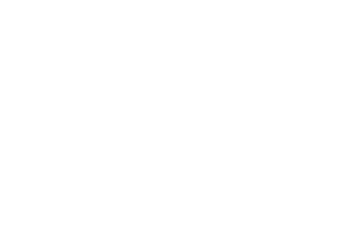

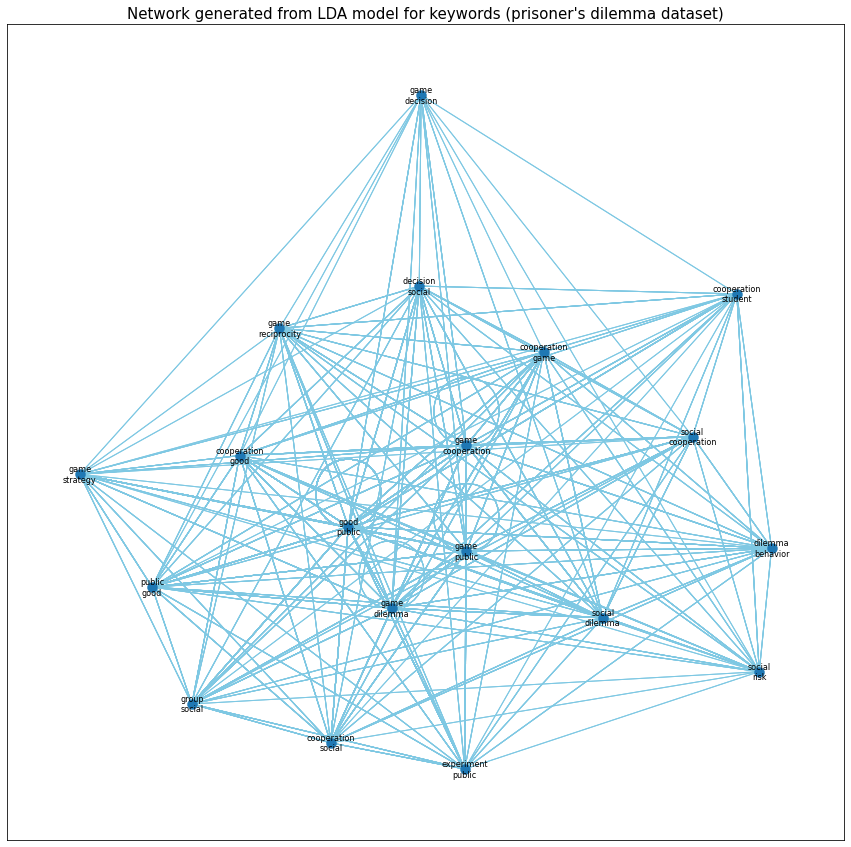

In [46]:
#create plot 2D

limits = plt.axis("off")
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title('Network generated from LDA model for keywords (prisoner\'s dilemma dataset)', 
             fontdict = {'fontsize': 15})
nx.draw_networkx(df2network(keywords_edges), node_size = 100, ax = ax, 
                 edge_color = '#7EC8E3',  linewidths = 0.4, font_size = 8)

In [47]:
#create interactive plot network
net = Network(notebook=True)

net.from_nx(df2network(keywords_edges))

net.show("LDA_net_keywords_prisoners.html")

In [48]:
abstracts_edges = generate_edges(create_dict_top2word(24, lda_abstracts))
abstracts_edges.to_csv("LDA_abstracts_prisoners_network_df.csv")

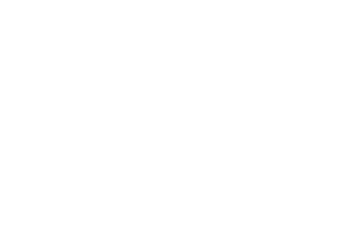

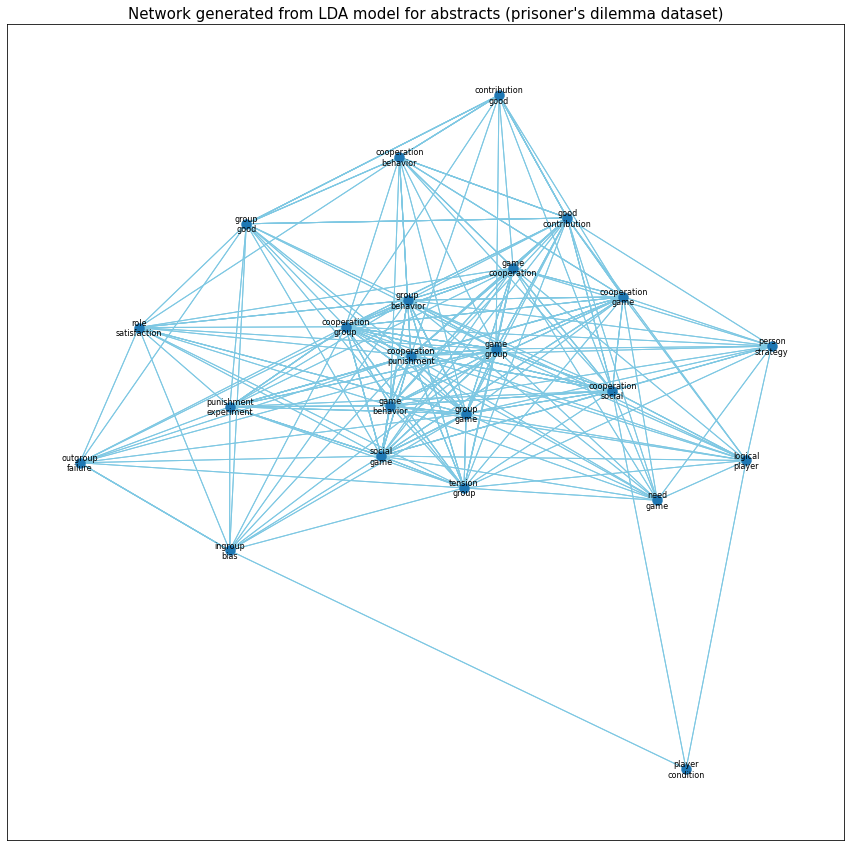

In [49]:
# create plot 2D

limits = plt.axis("off")
fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.set_title('Network generated from LDA model for abstracts (prisoner\'s dilemma dataset)', 
             fontdict = {'fontsize': 15})
nx.draw_networkx(df2network(abstracts_edges), node_size = 100, ax = ax, 
                 edge_color = '#7EC8E3',  linewidths = 0.4, font_size = 8)

In [50]:
#create interactive plot network
net = Network(notebook=True)

net.from_nx(df2network(abstracts_edges))

net.show("LDA_net_abstracts_prisoners_regulation.html")